In [1]:
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
tf.enable_v2_behavior()

In [2]:
# Compute the RMSE given the ground truth (y_true) and the predictions(y_pred)
def root_mean_squared_error(y_true, y_pred):
        return tf.math.sqrt(tf.math.reduce_mean(tf.math.square(y_pred - y_true), axis=-1))
    
class InputTransformedKernel(tfp.math.psd_kernels.PositiveSemidefiniteKernel):

    def __init__(self, kernel, transformation, name='InputTransformedKernel'):
        self._kernel = kernel
        self._transformation = transformation
        super(InputTransformedKernel, self).__init__(
            feature_ndims=kernel.feature_ndims,
            dtype=kernel.dtype,
            name=name)

    def apply(self, x1, x2):
        return self._kernel.apply(
            self._transformation(x1),
            self._transformation(x2))

    def matrix(self, x1, x2):
        return self._kernel.matrix(
            self._transformation(x1),
            self._transformation(x2))

    @property
    def batch_shape(self):
        return self._kernel.batch_shape

    def batch_shape_tensor(self):
        return self._kernel.batch_shape_tensor

class InputScaledKernel(InputTransformedKernel):

    def __init__(self, kernel, length_scales):
        super(InputScaledKernel, self).__init__(
            kernel,
            lambda x: x / tf.expand_dims(length_scales,
                                     -(kernel.feature_ndims + 1)))        

In [3]:
# Load labeled data
data = np.loadtxt('../data/labeled_data.dat')
x_labeled = data[:, :2].astype(np.float64) # -2 because we do not need porosity predictions
y_labeled = data[:, -2:-1].astype(np.float64) # dimensionless bond length and porosity measurements

# Normalize the data.
from sklearn import preprocessing

# normalize dataset with MinMaxScaler
scaler = preprocessing.MinMaxScaler(feature_range=(0.0, 1.0))
x_labeled = scaler.fit_transform(x_labeled)
# y_labeled = scaler.fit_transform(y_labeled)

tr_size = 30

# train and test data
trainX, trainY = x_labeled[:tr_size,:], y_labeled[:tr_size]
testX, testY = x_labeled[tr_size:,:], y_labeled[tr_size:]

trainY = np.transpose(trainY)
testY = np.transpose(testY)

data_phyloss = np.loadtxt('../data/unlabeled_data_BK_constw_v2_1525.dat')
x_unlabeled = data_phyloss[:, :]

# initial porosity
initporo = x_unlabeled[:, -1]

x_unlabeled1 = x_unlabeled[:1303, :2]
x_unlabeled2 = x_unlabeled[-6:, :2]
x_unlabeled = np.vstack((x_unlabeled1,x_unlabeled2))

x_unlabeled = scaler.fit_transform(x_unlabeled)
init_poro1 = initporo[:1303]
init_poro2 = initporo[-6:]
init_poro = np.hstack((init_poro1,init_poro2))

In [4]:
def build_gp(amplitude, length_scale):
    """Defines the conditional dist. of GP outputs, given kernel parameters."""

    # Create the covariance kernel, which will be shared between the prior (which we
    # use for maximum likelihood training) and the posterior (which we use for
    # posterior predictive sampling)    
    se_kernel = tfk.ExponentiatedQuadratic(amplitude)  # length_scale = None here, implicitly

    # This is the "ARD" kernel (we don't like abbreviations or bizarrely obscure names in
    # TFP, so we're probably going to call this "InputScaledKernel" since....that's what it is! :)
    kernel = InputScaledKernel(se_kernel, length_scale)
    
    # Create the GP prior distribution, which we will use to train the model
    # parameters.
    return tfd.GaussianProcess(kernel=kernel,index_points=trainX)

gp_joint_model = tfd.JointDistributionNamedAutoBatched({
    'amplitude': tfd.TransformedDistribution(
            distribution=tfd.Normal(loc=0., scale=np.float64(1.)),
            bijector=tfb.Exp(),
            batch_shape=[1]),
    'length_scale': tfd.TransformedDistribution(
            distribution=tfd.Normal(loc=0., scale=np.float64(1.)),
            bijector=tfb.Exp(),
            batch_shape=[2]),
    'observations': build_gp,
})

In [5]:
# Create the trainable model parameters, which we'll subsequently optimize.
# Note that we constrain them to be strictly positive.
constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

amplitude_var = tfp.util.TransformedVariable(
    initial_value=np.random.uniform(size=1),
    bijector=constrain_positive,
    name='amplitude',
    dtype=np.float64)

length_scale_var = tfp.util.TransformedVariable(
    initial_value=np.random.uniform(size=[2]),
    bijector=constrain_positive,
    name='length_scale',
    dtype=np.float64)

trainable_variables = [v.trainable_variables[0] for v in 
                       [amplitude_var,
                       length_scale_var]]

In [6]:
@tf.function(autograph=False, experimental_compile=False)
def target_log_prob(amplitude, length_scale):
    return -gp_joint_model.log_prob({
      'amplitude': amplitude,
      'length_scale': length_scale,
      'observations': trainY
  })

In [7]:
tf.random.set_seed(1234)

# Optimize the model parameters.
num_iters = 40
optimizer = tf.optimizers.Adam(learning_rate=.1)

# Store the likelihood values during training, so we can plot the progress
lls_ = np.zeros(num_iters, np.float64)

for i in range(num_iters):
    with tf.GradientTape() as tape:
        loss = target_log_prob(amplitude_var, length_scale_var)


    print(i,"loss_inloop:",loss)
    grads = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    lls_[i] = loss

print('Trained parameters:')
print('amplitude: {}'.format(amplitude_var._value().numpy()))
print('length_scale: {}'.format(length_scale_var._value().numpy()))

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
0 loss_inloop: tf.Tensor(178.8407220048977, shape=(), dtype=float64)
1 loss_inloop: tf.Tensor(174.41082627519688, shape=(), dtype=float64)
2 loss_inloop: tf.Tensor(170.71788943503248, shape=(), dtype=float64)
3 loss_inloop: tf.Tensor(168.2346726439364, shape=(), dtype=float64)
4 loss_inloop: tf.Tensor(167.3723240772366, shape=(), dtype=float64)
5 loss_inloop: tf.Tensor(166.48249688878684, shape=(), dtype=float64)
6 loss_inloop: tf.Tensor(164.96099210918345, shape=(), dtype=float64)
7 loss_inloop: tf.Tensor(163.3081526485371, shape=(), dtype=float64)
8 loss_inloop: tf.Tensor(162.06961633545532, shape=(), dtype=float64)
9 loss_inloop: tf.Tensor(161.4289366558662, shape=(), dtype=float64)
10 loss_inloop: tf.Tensor(161.20019419464936, shape=(), dtype=float64)
11 loss_inloop: tf.Tensor(161.12624921429307, shape=(), dtype=float64)
12 loss_inloop: tf.Tensor(161.04383511991205, shape=(), dtype=float64)
13 lo

In [8]:
tf.random.set_seed(1234)
se_kernel = tfk.ExponentiatedQuadratic(amplitude_var)  # length_scale = None here, implicitly
optimized_kernel = InputScaledKernel(se_kernel, length_scale_var)
gprm = tfd.GaussianProcessRegressionModel(kernel=optimized_kernel, index_points = testX)
samples = gprm.sample(1)
# optimized_kernel = tfk.ExponentiatedQuadratic(amplitude_var, length_scale_var)
# gpr = tfd.GaussianProcessRegressionModel(kernel=optimized_kernel, index_points = testX)
# samples = gpr.sample(1)
samples

<tf.Tensor: shape=(1, 1, 9), dtype=float64, numpy=
array([[[-0.03703226, -0.02586879, -0.00434636,  0.01429826,
          0.02323409,  0.01055448,  0.03093625, -0.03490037,
         -0.01291905]]])>

In [9]:
np.array(tf.squeeze(samples, axis=1)).shape

(1, 9)

In [10]:
testY

array([[0.0105933 , 0.03315482, 0.01352198, 0.05269549, 0.00490424,
        0.00895544, 0.01003564, 0.01345683, 0.02496436]])

In [11]:
root_mean_squared_error(testY, samples)

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.03665841]])>

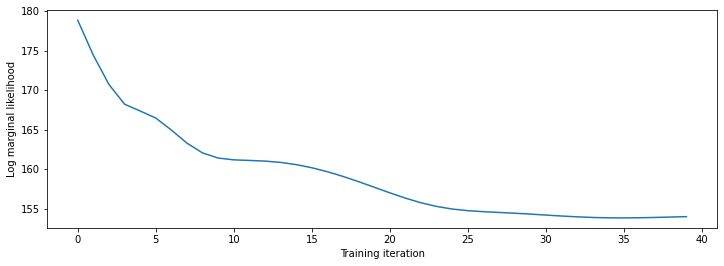

In [12]:
import matplotlib.pyplot as plt
# Plot the loss evolution
plt.figure(figsize=(12, 4))
plt.plot(lls_)
plt.xlabel("Training iteration")
plt.ylabel("Log marginal likelihood")
plt.show()